# SYDE 556/750 --- Assignment 3
**Student ID: 20823934**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

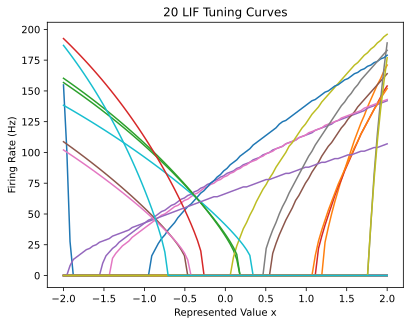

In [14]:
""" Set up the variables """

N = 100         # Number of samples per neuron
n = 20          # Number of neurons
r = 2           # Radius
tau_ref = 0.002 # 2 ms
tau_rc = 0.02   # 20 ms
np.random.seed(0)

x = np.linspace(-2, 2, N)                               # x-axis
a_max = np.random.uniform(low=100, high=200, size=n)    # Firing rates
xi = np.random.uniform(low=-2, high=2, size=n)          # x-intercepts
e = np.random.choice([-1, 1], size=n)                   # Encoder directions

""" Compute alpha and J^bias """

def G_inverse(a):
    return 1 / (1 - np.exp((tau_ref - 1/a)/(tau_rc)))

def G(J):
    if J > 1:
        return 1 / (tau_ref - tau_rc * np.log(1 - 1/J))
    else:
        return 0
G_vec = np.vectorize(G)

# Slightly change the formula for alpha to account for the radius
alpha = (G_inverse(a_max) - 1) / (r - xi)
J_bias = 1 - alpha * xi

""" Calculate the tuning curves """

A = []
for i in range(n):
    a = G_vec(e[i] * alpha[i] * x + J_bias[i])
    A.append(a)
A = np.array(A)

""" Plotting the curves """

def plot_A(x, A):
    for i in range(A.shape[0]):
        plt.plot(x, A[i])

    plt.title(f"{A.shape[0]} LIF Tuning Curves")
    plt.xlabel("Represented Value x")
    plt.ylabel("Firing Rate (Hz)")
    plt.show()

plot_A(x, A)

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

In [3]:
""" Add noise to A """

# Set a reliable seed
np.random.seed(100)

# Generate the noise
mu = 0
sigma = 0.2 * np.max(A)
noise = np.random.normal(mu, sigma, A.shape)

# Add the noise but don't allow negative firing rates
A_noisy = np.maximum(A + noise, 0)
plot_A(x, A_noisy)

""" Calculate the decoders """

# Naive optimal decoder
D = A @ x @ np.linalg.inv(A @ A.T)

# Regularized decoder
D_reg = A @ x @ np.linalg.inv(A @ A.T + N * np.square(sigma) * np.eye(n))

""" Plot the decoded signals and report the RMSEs """

print("Naive D, noise-less A")
rmse_d_a = plot_decoder_error(x, D, A)

print("Naive D, noisy A")
rmse_d_an = plot_decoder_error(x, D, A_noisy)

print("Regularized D, noise-less A")
rmse_dr_a = plot_decoder_error(x, D_reg, A)

print("Regularized D, noisy A")
rmse_dr_an = plot_decoder_error(x, D_reg, A_noisy)

""" Summarize the RMSEs """

rmses = [[rmse_d_a, rmse_d_an], [rmse_dr_a, rmse_dr_an]]
row_labels = ["Naive D", "Regularized D"]
col_labels = ["Noise-less A", "Noisy A"]
df = pd.DataFrame(rmses, index=row_labels, columns=col_labels)
print(df)

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

In [4]:
# ✍ <YOUR SOLUTION HERE>

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

In [5]:
# ✍ <YOUR SOLUTION HERE>

**c) Error analysis.** Compute the RMSE of the decoding.

In [6]:
# ✍ <YOUR SOLUTION HERE>

# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

In [7]:
# ✍ <YOUR SOLUTION HERE>

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

✍ \<YOUR SOLUTION HERE\>

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

In [8]:
# ✍ <YOUR SOLUTION HERE>

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

In [9]:
# ✍ <YOUR SOLUTION HERE>

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

In [10]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

✍ \<YOUR SOLUTION HERE\>

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [11]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [12]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [13]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [14]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

✍ \<YOUR SOLUTION HERE\>